In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

In [48]:
# import fredkey
fred = Fred(api_key='d59606a150e09c54fd5158bac863da0d') # Jeg skuler min nøkkel her. Skaff din egen.

In [49]:
# requesting data used in the Chauvet paper
series = {
    'MTS' : 'CMRMTSPL', # manufacturing and trade sales
    'PILTP' : 'W875RX1', # total personal income less transfer payments
    'ENAP' : 'PAYEMS', # employees on nonagricultural payrolls
    'IPMAN' : 'IPMAN' # industrial production
}

def gen_dataset(series: dict):
    lst = []
    for i in series.keys():
        data = fred.get_series(series[i])
        data = data.rename(i)
        lst.append(data)
    
    return pd.concat(lst, axis=1)

df = gen_dataset(series)
df = df.dropna()
df.head()

,MTS,PILTP,ENAP,IPMAN
1972-01-01,436061.565,4208.2,72441.0,35.9488
1972-02-01,431354.862,4231.9,72648.0,36.2194
1972-03-01,439346.765,4259.5,72944.0,36.4664
1972-04-01,442331.562,4273.3,73162.0,36.8786
1972-05-01,445055.610,4291.2,73469.0,36.9454


In [60]:
recession = fred.get_series('USRECDM')
recession.head()

1854-12-01    1.0
1854-12-02    1.0
1854-12-03    1.0
1854-12-04    1.0
1854-12-05    1.0
dtype: float64

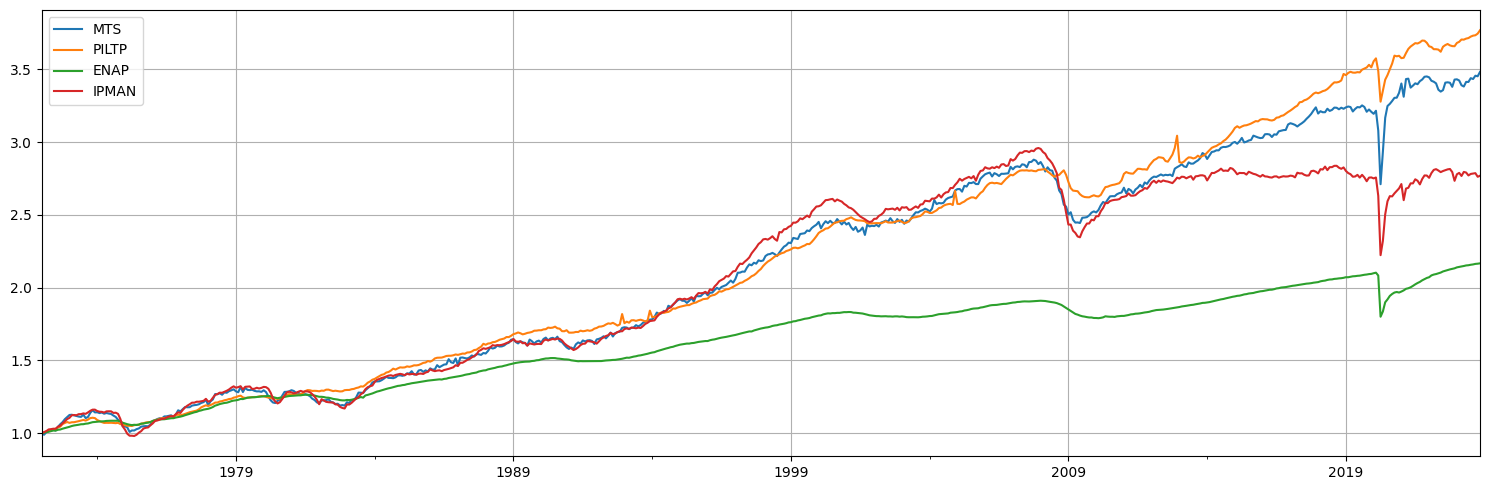

In [123]:
fig, ax = plt.subplots(figsize=(15, 5))

(df / df.iloc[0]).plot(ax=ax)

recession_period = recession.loc[recession.index.isin(df.index)]
ax.fill_between(df.index, df.min().min(), df.max().max(), where=recession_period.values, color="k", alpha=0.3)

plt.grid()
plt.tight_layout()
plt.show()


In [86]:
recession_period.astype('bool').values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

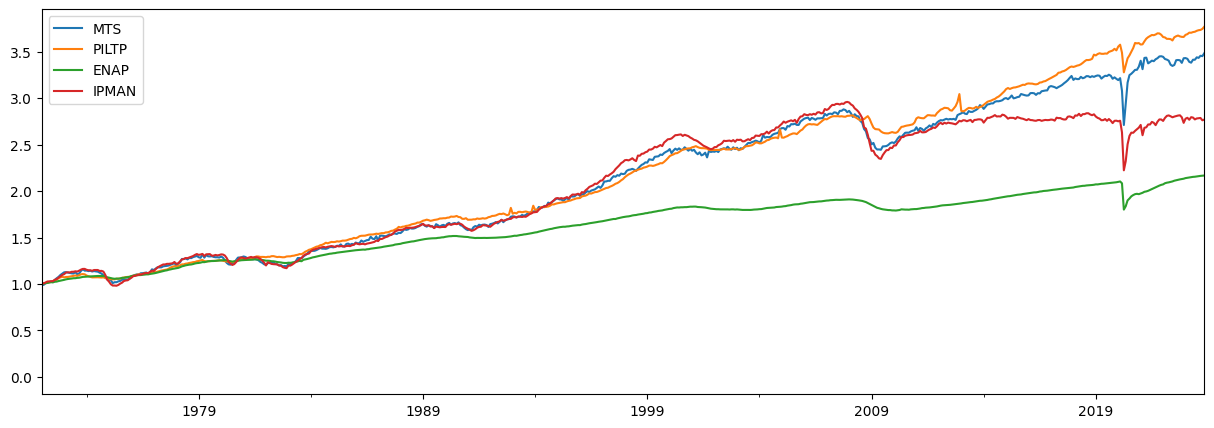

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
(df/df.iloc[0]).plot(ax=ax)

recession_period = recession.loc[recession.index.isin(df.index)]

ax.fill_between(recession_period.index, 0, 1, where=recession_period.squeeze(), color="k", alpha=0.1)
plt.show()

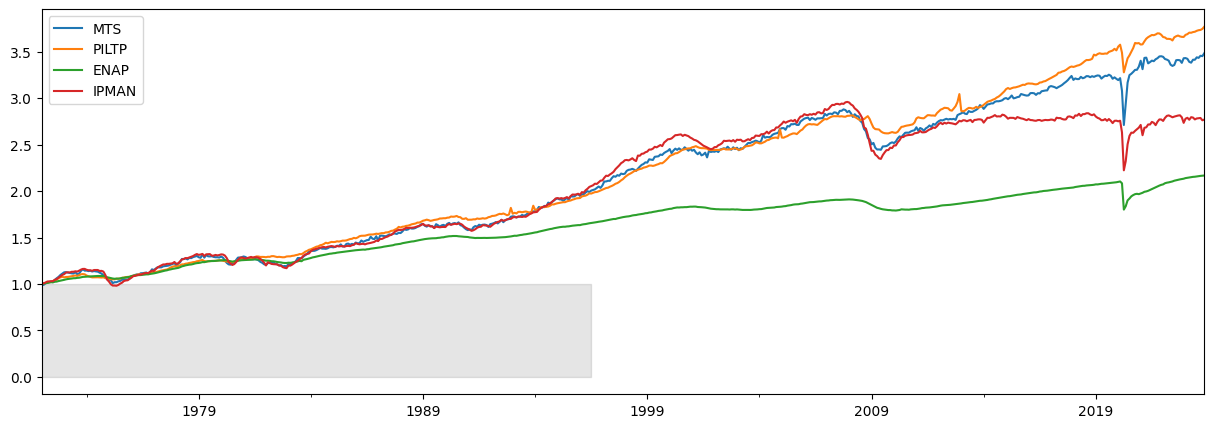

In [66]:
(df/df.iloc[0]).plot(figsize=(15,5))
plt.fill_between(recession.index, 0, 1, where=recession.values, color="k", alpha=0.1)
plt.show()

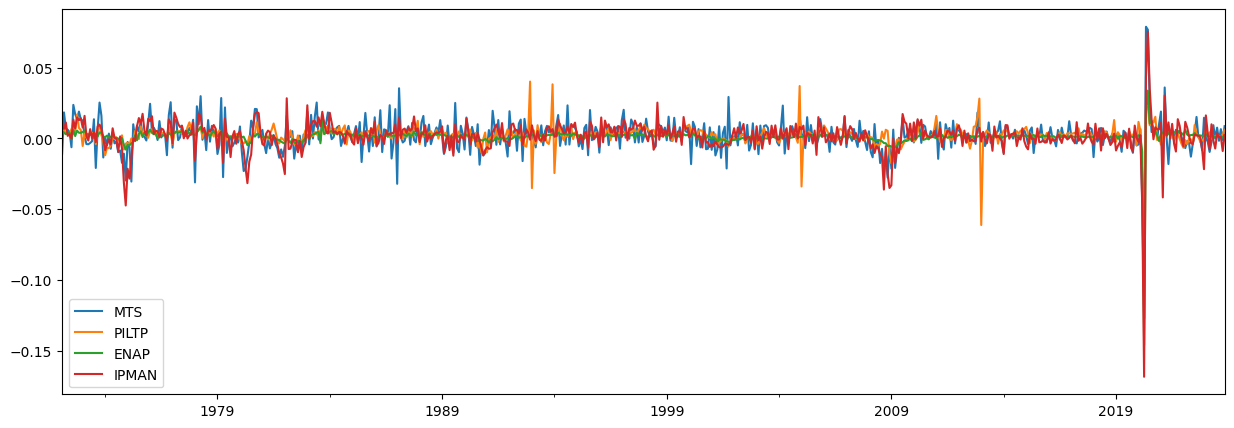

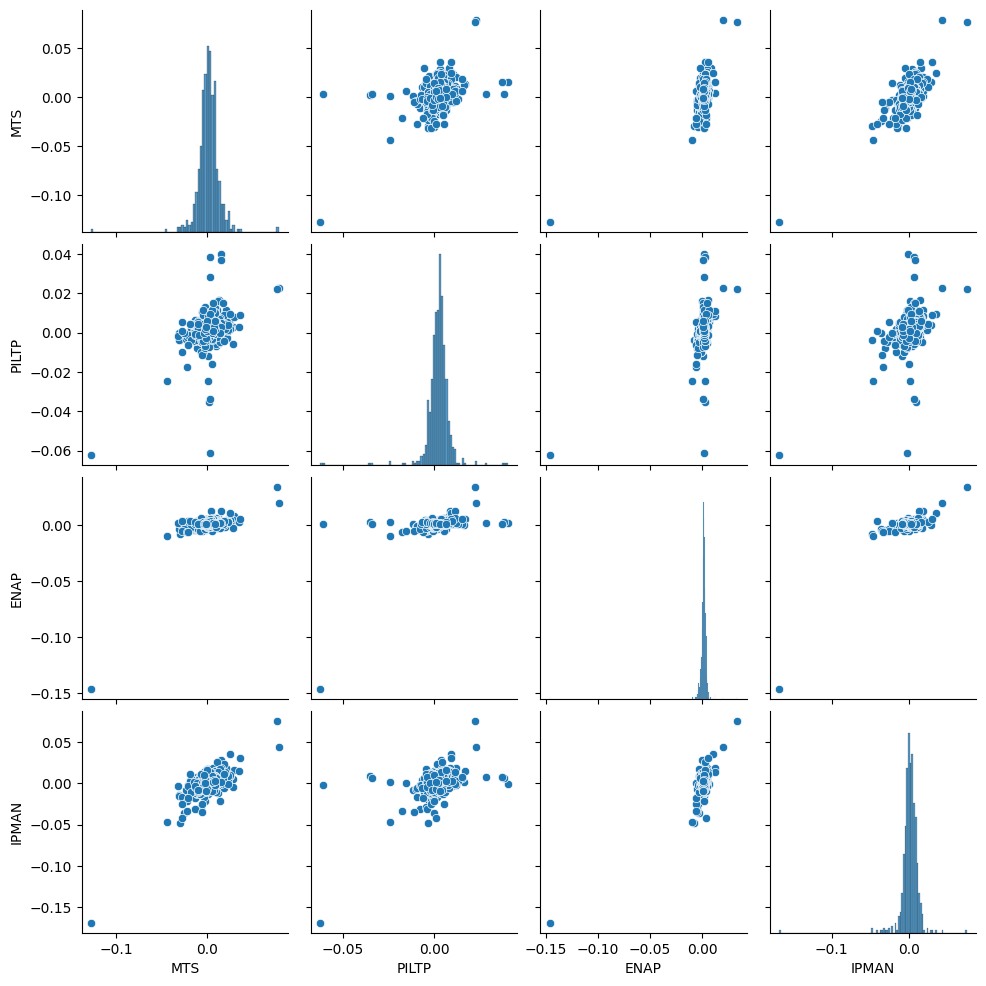

In [56]:
df2 = df.apply(lambda x: np.log(x))
df2 = df2.diff()
df2 = df2.dropna()
df2.plot(figsize=(15,5))
plt.show()

import seaborn as sns
sns.pairplot(df2)
plt.show()

# Factor model without switching

In [53]:
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
dfm = DynamicFactor(
    df2, 
                                      k_factors=2, 
                                      factor_order=2, 
                                      error_order=2,
                                      error_var=False,
                                      enforce_stationarity=False
                                      )

res = dfm.fit(maxiter=500)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.24193D+00    |proj g|=  4.85250D+01

At iterate    5    f= -8.79073D+00    |proj g|=  2.96654D+01

At iterate   10    f= -1.04029D+01    |proj g|=  3.43043D+01

At iterate   15    f= -1.09839D+01    |proj g|=  1.67713D+02

At iterate   20    f= -1.15392D+01    |proj g|=  4.05915D+01

At iterate   25    f= -1.16347D+01    |proj g|=  5.79150D+00

At iterate   30    f= -1.16573D+01    |proj g|=  1.86861D+01

At iterate   35    f= -1.17361D+01    |proj g|=  1.87717D+01

At iterate   40    f= -1.17728D+01    |proj g|=  1.04583D+01

At iterate   45    f= -1.19576D+01    |proj g|=  3.33404D+01

At iterate   50    f= -1.27885D+01    |proj g|=  4.82819D+01

At iterate   55    f= -1.35876D+01    |proj g|=  4.58100D+01

At iterate   60    f= -1.40843D+01    |proj g|=  2.27520D+01

At iterate   65    f= -1.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [54]:
print(res.summary())

                                   Statespace Model Results                                  
Dep. Variable:     ['MTS', 'PILTP', 'ENAP', 'IPMAN']   No. Observations:                  622
Model:             DynamicFactor(factors=2, order=2)   Log Likelihood                8905.737
                                      + AR(2) errors   AIC                         -17755.473
Date:                               Thu, 01 Feb 2024   BIC                         -17631.351
Time:                                       16:40:26   HQIC                        -17707.233
Sample:                                   02-01-1972                                         
                                        - 11-01-2023                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):     1.43, 3.78, 2.62, 0.01   Jarque-Bera (JB):   21647.69, 20142.24, 1172481.81, 399.50
Prob(Q):                0.23, 0.05, 0.11, 0.93